## Intro:

Website for dataset: 
https://archive.ics.uci.edu/ml/datasets/bank+marketing

What we are predicting:
- Whether a certain client subscribes to a bank term deposit ("yes" or "no")

##### The Dataset:
- The original dataset consists of a total of 20 independent variables plus a y-variable (binary - "yes", "no")



## Importing necessary libraries:

In [333]:
import pandas as pd
import numpy as np
import scipy as sc
import seaborn as sns
from copy import deepcopy
from collections import OrderedDict

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

import matplotlib.pyplot as plt
import scikitplot as skplt
%matplotlib inline

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 1000
pd.set_option('precision',2)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline

# Data Preprocessing:
#### Function for converting categorical variables into dummy variables

In [647]:
lst = ['marital', 'education', 'job', 'contact', 'poutcome']
def make_dummies(df, lst):
    temp = deepcopy(df)
    Y = df['y']
    temp = temp.drop(['y'], axis=1)
    for col in temp:
        if temp[col].dtype == 'object':
            tmp = pd.get_dummies(temp[col], prefix=col)
            num_col = len(tmp.columns)
            tmp = tmp.iloc[:,0:num_col-1]
            temp.drop([col], axis=1,inplace=True)
            lst = [temp, tmp]
            temp = pd.concat(lst, axis=1)
    return temp, Y

In [5]:
df_bankFull = pd.read_csv("bank-full.csv", delimiter=";")
df_bank = pd.read_csv("bank.csv", delimiter=";")

#### Standardizing Numerical Variables

- Standardizing the data is essential for clustering algorithms and dimension reduction.
- It's not necessary for tree based algorithms.

In [46]:
dfBankFull = deepcopy(df_bankFull)
cols_to_norm = ['age', 'balance', 'duration', 'day','campaign', 'pdays','previous']
dfBankFull[cols_to_norm] = dfBankFull[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max()-x.min()))

#### Categorical Variables to Dummies

In [47]:
mainDF, y = make_dummies(dfBankFull, lst)

#### Downsampling Majority Class:

- In the cell directly below you can see the big imbalance between the two classes we're trying to predict. We're going to need to fix this so when it's fed into our models there is no prediction bias toward any one class.

In [48]:
y.value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [49]:
from sklearn.utils import resample

In [255]:
frames = [mainDF, y]
df = pd.concat(frames, axis=1)
df_maj = df[df.y=='no']
df_min = df[df.y=='yes']
df_majority_downsampled = resample(df_maj, replace=False,
                                  n_samples=5289,
                                  random_state=101)

frames_resampled = [df_majority_downsampled,df_min]
df_resampled = pd.concat(frames_resampled)

##### Results after downsampling the majority class:

In [256]:
df_resampled['y'].value_counts()

no     5289
yes    5289
Name: y, dtype: int64

In [558]:
x_train, x_test, y_train, y_test = train_test_split(df_resampled.drop(['y'], axis=1),df_resampled['y'], test_size=.3, random_state=101)

# Random Forests

#### How class_weights parameter was calculated: 
    - for 'no': sample_A / total_sample_size
            - 39922 / (39922+5289) = .88
         
    - for 'yes': sample_A / total_sample_size
            - 5289 / (39922+5289) = .12

#### Training & Predicting:

In [641]:
rf = RandomForestClassifier(n_estimators=397,
                            class_weight={'no':8.8, 'yes':1.2},
                            bootstrap=True,max_features=12,
                            oob_score=True,random_state=101).fit(x_train, y_train)


y_pred = rf.predict(x_test)
y_probas = rf.predict_proba(x_test)

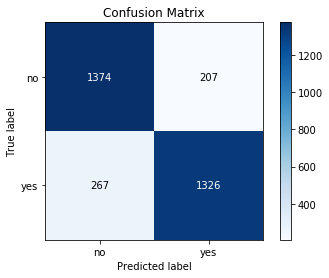

In [650]:
skplt.metrics.plot_confusion_matrix(y_test,y_pred)

In [643]:
#print(confusion_matrix(y_test, prediction,labels=['no','yes']))
print(pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))
print(classification_report(y_test, y_pred))
print('Training set accuracy')
print(rf.score(x_train,y_train))
print('\n')
print('Test set accuracy')
print(accuracy_score(y_test, y_pred))
print(rf.score(x_test, y_test))

Predicted    no   yes
Actual               
no         1291   290
yes         165  1428
             precision    recall  f1-score   support

         no       0.89      0.82      0.85      1581
        yes       0.83      0.90      0.86      1593

avg / total       0.86      0.86      0.86      3174

Training set accuracy
1.0


Test set accuracy
0.8566477630749842
0.8566477630749842


### Plotting Receiver Operating Characteristic (ROC) Curve:

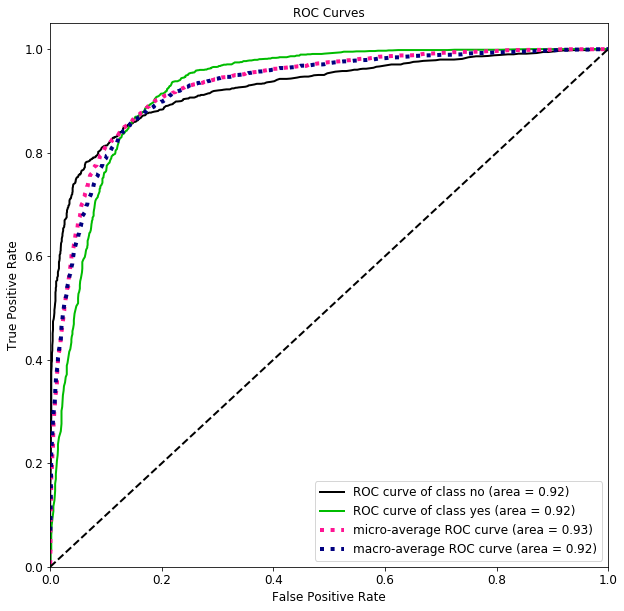

In [644]:
skplt.metrics.plot_roc_curve(y_test, y_probas,
                             figsize=(10,10),text_fontsize='large')

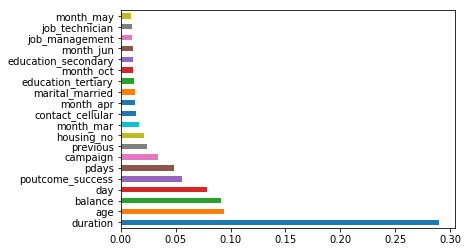

In [645]:
feat_imp = pd.Series(rf.feature_importances_, index=x_train.columns)
feat_imp = feat_imp.nlargest(20)
feat_imp.plot(kind='barh')

In [646]:
import warnings

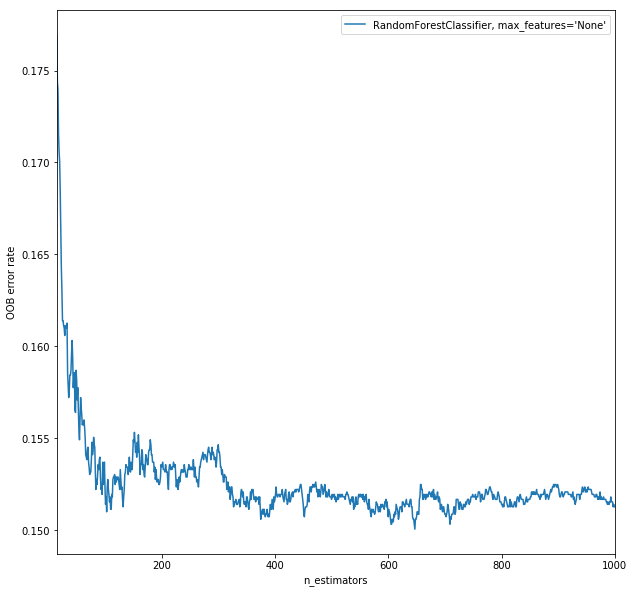

In [382]:
warnings.filterwarnings("ignore")

RANDOM_STATE = 101
ensemble_clfs = [
    ("RandomForestClassifier, max_features='None'",
     RandomForestClassifier(class_weight={'no':8.8, 'yes':1.2},
                            warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)


# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 1000
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(x_train, y_train)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.figure(figsize=(10,10))
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

In [391]:
lst = []
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    lst.append(xs)
    lst.append(ys)
error_df = pd.DataFrame(list(zip(lst[0],lst[1])))

#### Getting the n_estimators with lowest OOB score:

print('OOB Report:')
print("Number of estimators: {:<15} OOB error score: {:<15}".format(error_df.iloc[error_df[1].argmin(),:][0], np.round(error_df.iloc[error_df[1].argmin(),:][1],4)))

632

#### feature selection

In [592]:
from sklearn.feature_selection import SelectFromModel

In [635]:
sfm = SelectFromModel(rf, threshold=0.011)
sfm.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight={'no': 8.8, 'yes': 1.2},
            criterion='gini', max_depth=12, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=397, n_jobs=1, oob_score=True, random_state=101,
            verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=0.011)

##### transform dataset

In [636]:
transformed_x_train = sfm.transform(x_train)
transformed_x_test = sfm.transform(x_test)

In [637]:
num_features = transformed_x_train.shape[1]

##### train and predict with new RF based on transformed dataset:

In [638]:
rf_imp = RandomForestClassifier(n_estimators=397,
                                class_weight={'no':8.8, 'yes':1.2},
                                bootstrap=True,
                                max_features=num_features,min_samples_leaf=2,
                                oob_score=True,
                                random_state=101).fit(transformed_x_train, y_train)
imp_y_pred = rf_imp.predict(transformed_x_test)
imp_y_probas = rf_imp.predict_proba(transformed_x_test)

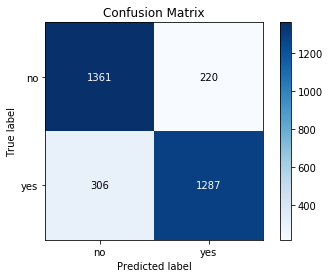

In [639]:
skplt.metrics.plot_confusion_matrix(y_test,imp_y_pred)

In [640]:
print(classification_report(y_test, imp_y_pred))
print('Training set accuracy')
print(rf_imp.score(transformed_x_train,y_train))
print('\n')
print('Test set accuracy')
print(accuracy_score(y_test, imp_y_pred))
print(rf_imp.score(transformed_x_test, y_test))

             precision    recall  f1-score   support

         no       0.82      0.86      0.84      1581
        yes       0.85      0.81      0.83      1593

avg / total       0.84      0.83      0.83      3174

Training set accuracy
0.9709616423554835


Test set accuracy
0.8342785129174544
0.8342785129174544


In [601]:
from sklearn.model_selection import GridSearchCV

In [521]:
params = {'max_features':np.arange(4,15,1),
          'min_samples_leaf':np.arange(2,20,2),
         'max_depth':np.arange(5,20,5),
         'n_estimators':[88],'bootstrap':[True]}

grid_rf = RandomForestClassifier()
clf = GridSearchCV(grid_rf, params).fit(x_train, y_train)


In [523]:
clf.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features=12, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=88, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [602]:
rf2 = RandomForestClassifier(n_estimators=397,
                            class_weight={'no':8.8, 'yes':1.2},
                            bootstrap=True,max_features=12,
                            oob_score=True,random_state=101,
                            min_samples_leaf=2).fit(x_train, y_train)
rf2_y_pred = rf2.predict(x_test)
rf2_y_probas = rf2.predict_proba(x_test)

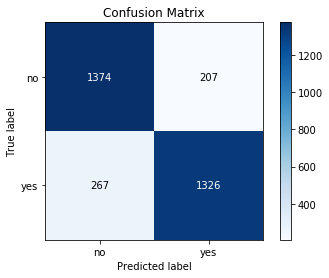

In [603]:
skplt.metrics.plot_confusion_matrix(y_test,rf2_y_pred)

In [604]:
#print(pd.crosstab(y_test, rf2_y_pred, rownames=['Actual'], colnames=['Predicted']))
print(classification_report(y_test, rf2_y_pred))
print('Training set accuracy')
print(rf2.score(x_train,y_train))
print('\n')
print('Test set accuracy')
print(accuracy_score(y_test, rf2_y_pred))
print(rf2.score(x_test, y_test))

             precision    recall  f1-score   support

         no       0.84      0.87      0.85      1581
        yes       0.86      0.83      0.85      1593

avg / total       0.85      0.85      0.85      3174

Training set accuracy
0.9715018908698001


Test set accuracy
0.8506616257088847
0.8506616257088847


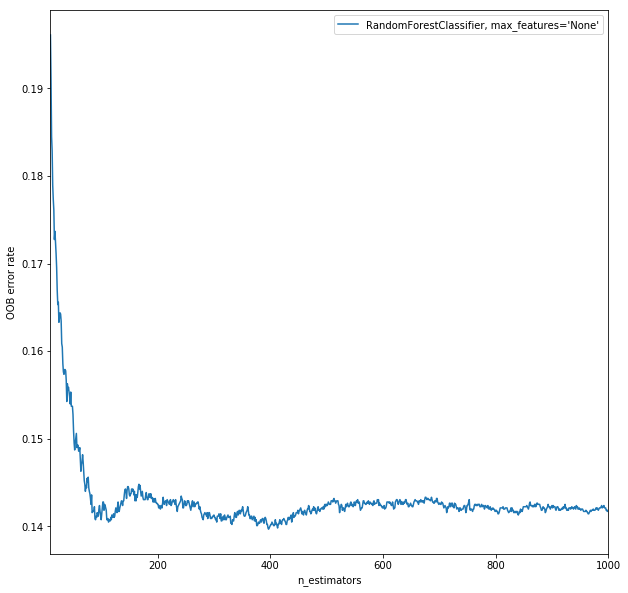

In [559]:
warnings.filterwarnings("ignore")

RANDOM_STATE = 101
ensemble_clfs = [
    ("RandomForestClassifier, max_features='None'",
     RandomForestClassifier(class_weight={'no':8.8, 'yes':1.2},
                            warm_start=True, max_features=12,
                            bootstrap=True,oob_score=True,
                            random_state=RANDOM_STATE))
]


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)


# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 1000
for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
            clf.set_params(n_estimators=i)
            clf.fit(x_train, y_train)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.figure(figsize=(10,10))
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

In [577]:
lst = []
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    lst.append(xs)
    lst.append(ys)
error_df = pd.DataFrame(list(zip(lst[0],lst[1])))

#### Getting the n_estimators with lowest OOB score:
print('OOB Report:')
print("Number of estimators: {:<15} OOB error score: {:<15}".format(error_df.iloc[error_df[1].argmin(),:][0], np.round(error_df.iloc[error_df[1].argmin(),:][1],4)))

OOB Report:
Number of estimators: 397.0           OOB error score: 0.1397         
